In [21]:
import tushare as ts

#df = ts.bar('000001', conn=cons, asset='INDEX', start_date='2016-01-01', end_date='')
#print(df)
df=ts.get_hist_data('000001',start='2016-01-01')
df.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2019-11-15,16.39,16.55,16.37,16.24,453359.84,0.05,0.31,16.326,16.620,16.642,609432.41,753383.37,898102.01
2019-11-14,16.43,16.48,16.32,16.25,468899.56,-0.01,-0.06,16.382,16.669,16.649,688588.28,833512.94,935273.97
2019-11-13,16.29,16.46,16.33,16.06,655120.62,0.00,0.00,16.496,16.663,16.668,737187.76,872879.90,968138.11
2019-11-12,16.29,16.37,16.33,16.16,516266.41,0.05,0.31,16.622,16.673,16.691,778828.71,892799.56,998765.64
2019-11-11,16.50,16.53,16.28,16.20,953515.62,-0.37,-2.22,16.786,16.731,16.733,910072.60,920059.40,1017050.09


In [22]:
df = df.dropna()

#df.to_csv('sh300.csv')

In [23]:
df.columns
df.describe()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
count,612.000000,612.000000,612.000000,612.000000,6.120000e+02,612.000000,612.000000,612.000000,612.000000,612.000000,6.120000e+02,6.120000e+02,6.120000e+02
mean,11.818840,11.998235,11.837794,11.667451,1.120443e+06,0.013039,0.129183,11.812984,11.781257,11.717487,1.119992e+06,1.118900e+06,1.116357e+06
std,2.029176,2.073921,2.032661,1.989382,6.020715e+05,0.253565,2.082608,2.010612,1.982792,1.922032,4.698138e+05,4.267671e+05,3.810388e+05
min,8.600000,8.700000,8.600000,8.450000,1.200000e+01,-1.080000,-7.710000,8.630000,8.718000,8.718000,3.130033e+05,3.130033e+05,3.130033e+05
25%,10.290000,10.437500,10.297500,10.170000,6.902788e+05,-0.120000,-1.040000,10.282000,10.335750,10.257250,7.595474e+05,7.859569e+05,8.276928e+05
50%,11.385000,11.560000,11.405000,11.250000,9.750531e+05,0.000000,0.000000,11.392000,11.388000,11.320000,1.012404e+06,1.021959e+06,1.064892e+06
75%,13.282500,13.575000,13.362500,13.135000,1.360288e+06,0.142500,1.247500,13.367000,13.321250,13.259500,1.362824e+06,1.329355e+06,1.319627e+06
max,17.260000,17.600000,17.220000,16.920000,4.262826e+06,1.070000,8.750000,16.956000,16.792000,16.788000,2.960232e+06,2.439934e+06,2.286892e+06


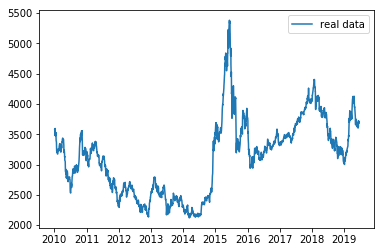

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

n = 30
LR = 0.001
EPOCH = 200
batch_size=20
train_end =-600

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#通过一个序列来生成一个31*(count(*)-train_end)矩阵（用于处理时序的数据）
#其中最后一列维标签数据。就是把当天的前n天作为参数，当天的数据作为label
def generate_data_by_n_days(series, n, index=False):
    if len(series) <= n:
        raise Exception("The Length of series is %d, while affect by (n=%d)." % (len(series), n))
    df = pd.DataFrame()
    for i in range(n):
        df['c%d' % i] = series.tolist()[i:-(n - i)]        
    df['y'] = series.tolist()[n:]
    
    if index:
        df.index = series.index[n:]
    return df

#参数n与上相同。train_end表示的是后面多少个数据作为测试集。
def readData(column='high', n=30, all_too=True, index=False, train_end=-500):
    df = pd.read_csv("sh300.csv", index_col=0)
    #以日期为索引
    df.index = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"), df.index))
    #获取每天的最高价
    df_column = df[column].copy()
    #拆分为训练集和测试集
    df_column_train, df_column_test = df_column[:train_end], df_column[train_end - n:]
    #生成训练数据
    df_generate_train = generate_data_by_n_days(df_column_train, n, index=index)
    if all_too:
        return df_generate_train, df_column, df.index.tolist()
    return df_generate_train



df, df_all, df_index = readData('high', n = n, train_end = train_end)
df_all= np.array(df_all.tolist())
plt.plot(df_index, df_all, label='real data')
plt.legend(loc='upper right')


In [25]:
class RNN(nn.Module):
    def __init__(self, input_size):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(64, 1)
        )

    def forward(self, x):
        r_out, (h_n, h_c) = self.rnn(x, None)  #None即隐层状态用0初始化
        out = self.out(r_out)
        return out


class mytrainset(Dataset):
    def __init__(self, data):        
        self.data, self.label = data[:, :-1].float(), data[:, -1].float()
             
    def __getitem__(self, index):
        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

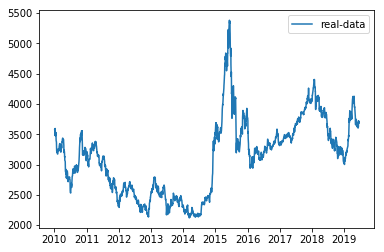

In [26]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
# 获取训练数据、原始数据、索引等信息
df, df_all, df_index = readData('high', n=n, train_end=train_end)

#可视化原高价数据
df_all = np.array(df_all.tolist())
plt.plot(df_index, df_all, label='real-data')
plt.legend(loc='upper right')  


#对数据进行预处理，规范化及转换为Tensor
df_numpy = np.array(df)

df_numpy_mean = np.mean(df_numpy)
df_numpy_std = np.std(df_numpy)

df_numpy = (df_numpy - df_numpy_mean) / df_numpy_std
df_tensor = torch.Tensor(df_numpy)


trainset = mytrainset(df_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)

In [27]:
#记录损失值，并用tensorboardx在web上展示
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='logs')

rnn = RNN(n).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)  
loss_func = nn.MSELoss()

for step in range(EPOCH):
    for tx, ty in trainloader:
        tx=tx.to(device)
        ty=ty.to(device)
        #在第1个维度上添加一个维度为1的维度，形状变为[batch,seq_len,input_size]
        output = rnn(torch.unsqueeze(tx, dim=1)).to(device)
        loss = loss_func(torch.squeeze(output), ty)
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()
    writer.add_scalar('sh300_loss', loss, step)  

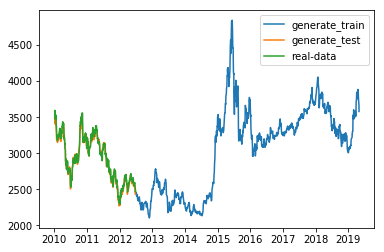

In [28]:
generate_data_train = []
generate_data_test = []

test_index = len(df_all) + train_end

df_all_normal = (df_all - df_numpy_mean) / df_numpy_std
df_all_normal_tensor = torch.Tensor(df_all_normal)
for i in range(n, len(df_all)):
    x = df_all_normal_tensor[i - n:i].to(device)
    #rnn的输入必须是3维，故需添加两个1维的维度，最后成为[1,1,input_size]
    x = torch.unsqueeze(torch.unsqueeze(x, dim=0), dim=0)
    
    y = rnn(x).to(device)
    if i < test_index:
        generate_data_train.append(torch.squeeze(y).detach().cpu().numpy() * df_numpy_std + df_numpy_mean)
    else:
        generate_data_test.append(torch.squeeze(y).detach().cpu().numpy() * df_numpy_std + df_numpy_mean)
plt.plot(df_index[n:train_end], generate_data_train, label='generate_train')
plt.plot(df_index[train_end:], generate_data_test, label='generate_test')
plt.plot(df_index[train_end:], df_all[train_end:], label='real-data')
plt.legend()
plt.show()